In [1]:
import os
import numpy as np
import pandas as pd
import torchvision
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import tqdm

from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models

from PIL import Image
# from google.colab import drive

In [2]:
# drive.mount('/content/gdrive')

In [3]:
# !unzip gdrive/My\ Drive/AML/Project.zip

# Create custom dataset

In [4]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform = None, target_transform = None):        
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):        
        return len(self.img_labels)

    def __getitem__(self, idx):        
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = Image.open(img_path)
        label = self.img_labels.iloc[idx, 1] - 1    
        if self.transform:
            image = self.transform(image)           
        if self.target_transform:
            label = self.target_transform(label)
            
        return image, label

# Model

In [5]:
# this is the model choice
model = models.resnet18(pretrained = True) # :)

model.fc = nn.Linear(model.fc.in_features, 80) # there are 80 classes, so the number of out_features is 80

In [6]:
# cuda or cpu
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cuda device


In [7]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    correct = 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device) #CASPER
        # Compute prediction and loss
        pred = model(X.float().to(device)) # only works when X is a float
        loss = loss_fn(pred, y.to(device))
        correct += (pred.argmax(1) == y).type(torch.float).sum().item() #CASPER

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step() # update parameters / weights

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss: > 7f}  [{current: > 5d} / {size: > 5d}]")
            
    correct /= size #CASPER
    return (loss, (100 * correct)) #CASPER

def val_loop(dataloader, model, loss_fn):
    confusion_matrix = torch.zeros(80, 80) # Julian toegevoegd
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X.float()) # only works when X is a float
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            confusion_matrix[y, pred.argmax(1)] += 1 # Julian toegevoegd

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100 * correct): > 0.1f}%, Avg loss: {test_loss: > 8f} \n") 
    print(confusion_matrix)
    return (test_loss, (100 * correct)), confusion_matrix #CASPER
    
def test_loop(dataloader, model):
    pred_label = []
    model.eval() # to ensure that this is the test run

    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            pred = model(X.float())
            pred_label.append(pred.argmax(1))
    
    return pred_label

In [8]:
model.to(device = device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Load data 

In [9]:
# directories for dataset_train
annotations_file_train = 'train_labels.csv'
img_dir_train = 'train_set_backup'

# directories for dataset_test
annotations_file_test = 'sample.csv' # you won't use this, but it's needed for the code to run
img_dir_test = 'test_set/test_set'

# transform is used for train and test
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]),
])

# these datasets are used to create the dataloaders
dataset_train = CustomImageDataset(annotations_file_train, img_dir_train, transform)
dataset_test = CustomImageDataset(annotations_file_test, img_dir_test, transform)

In [10]:
# change one of these to test different scores
batch_size = 64 # determines after how images parameters / weights are updated 
learning_rate = 0.001 # trade-off between speed and accuracy 
epochs = 3 # how many times you loop over your dataset

# change the loss function to test different scores
loss_fn = nn.CrossEntropyLoss() # hierna de NLLLoss proberen, why are these the same?

# don't change this one
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate) # gradient descent

In [11]:
# split train set into train and validation
train_size = int(0.8 * len(dataset_train))
val_size = len(dataset_train) - train_size # 0.2

train_subset, val_subset = torch.utils.data.random_split(
        dataset_train, [train_size, val_size], generator = torch.Generator().manual_seed(1))

# used for train and val loop
train_dataloader = DataLoader(train_subset, batch_size = batch_size, shuffle = True)
val_dataloader = DataLoader(val_subset, batch_size = batch_size, shuffle = True)

# used for test loop
test_dataloader = DataLoader(dataset_test)

# Train model

In [13]:
train_data_list = [] #CASPER
val_data_list = [] #CASPER
confusion_matrices = [] # Julian

# train model
for t in range(epochs):
    print(f"Epoch {t + 1} \n-------------------------------")
    for param in model.parameters():
        param.requires_grad = t > 5 # freeze first five epochs to decrease training time --> but we have to freeze the first few layers
        # param.requires_grad = False
    for param in model.fc.parameters():
        param.requires_grad = True

    train_data = train_loop(train_dataloader, model, loss_fn, optimizer) #CASPER
    train_data_list.append(train_data) #CASPER
    
    val_data, confusion_matrix = val_loop(val_dataloader, model, loss_fn) #CASPER Julian
    val_data_list.append(val_data) #CASPER
    confusion_matrices.append(confusion_matrix) # Julian
    
print("Done!")

Epoch 1 
-------------------------------
loss:  4.677481  [    0 /  24489]
loss:  3.433559  [ 6400 /  24489]
loss:  2.812265  [ 12800 /  24489]
loss:  2.812430  [ 19200 /  24489]
Test Error: 
 Accuracy:  41.5%, Avg loss:  2.454092 

tensor([[36.,  4.,  0.,  ...,  0.,  2.,  0.],
        [ 0., 51.,  3.,  ...,  0.,  1.,  0.],
        [ 1.,  7., 30.,  ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0.,  ..., 27.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  1., 49.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  7.]])
Epoch 2 
-------------------------------
loss:  2.451382  [    0 /  24489]
loss:  2.127235  [ 6400 /  24489]
loss:  2.062321  [ 12800 /  24489]
loss:  2.059951  [ 19200 /  24489]
Test Error: 
 Accuracy:  45.6%, Avg loss:  2.212598 

tensor([[38.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 2., 46.,  4.,  ...,  0.,  0.,  0.],
        [ 1.,  1., 34.,  ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0.,  ..., 31.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  2., 23.,  0.],
 

<AxesSubplot:>

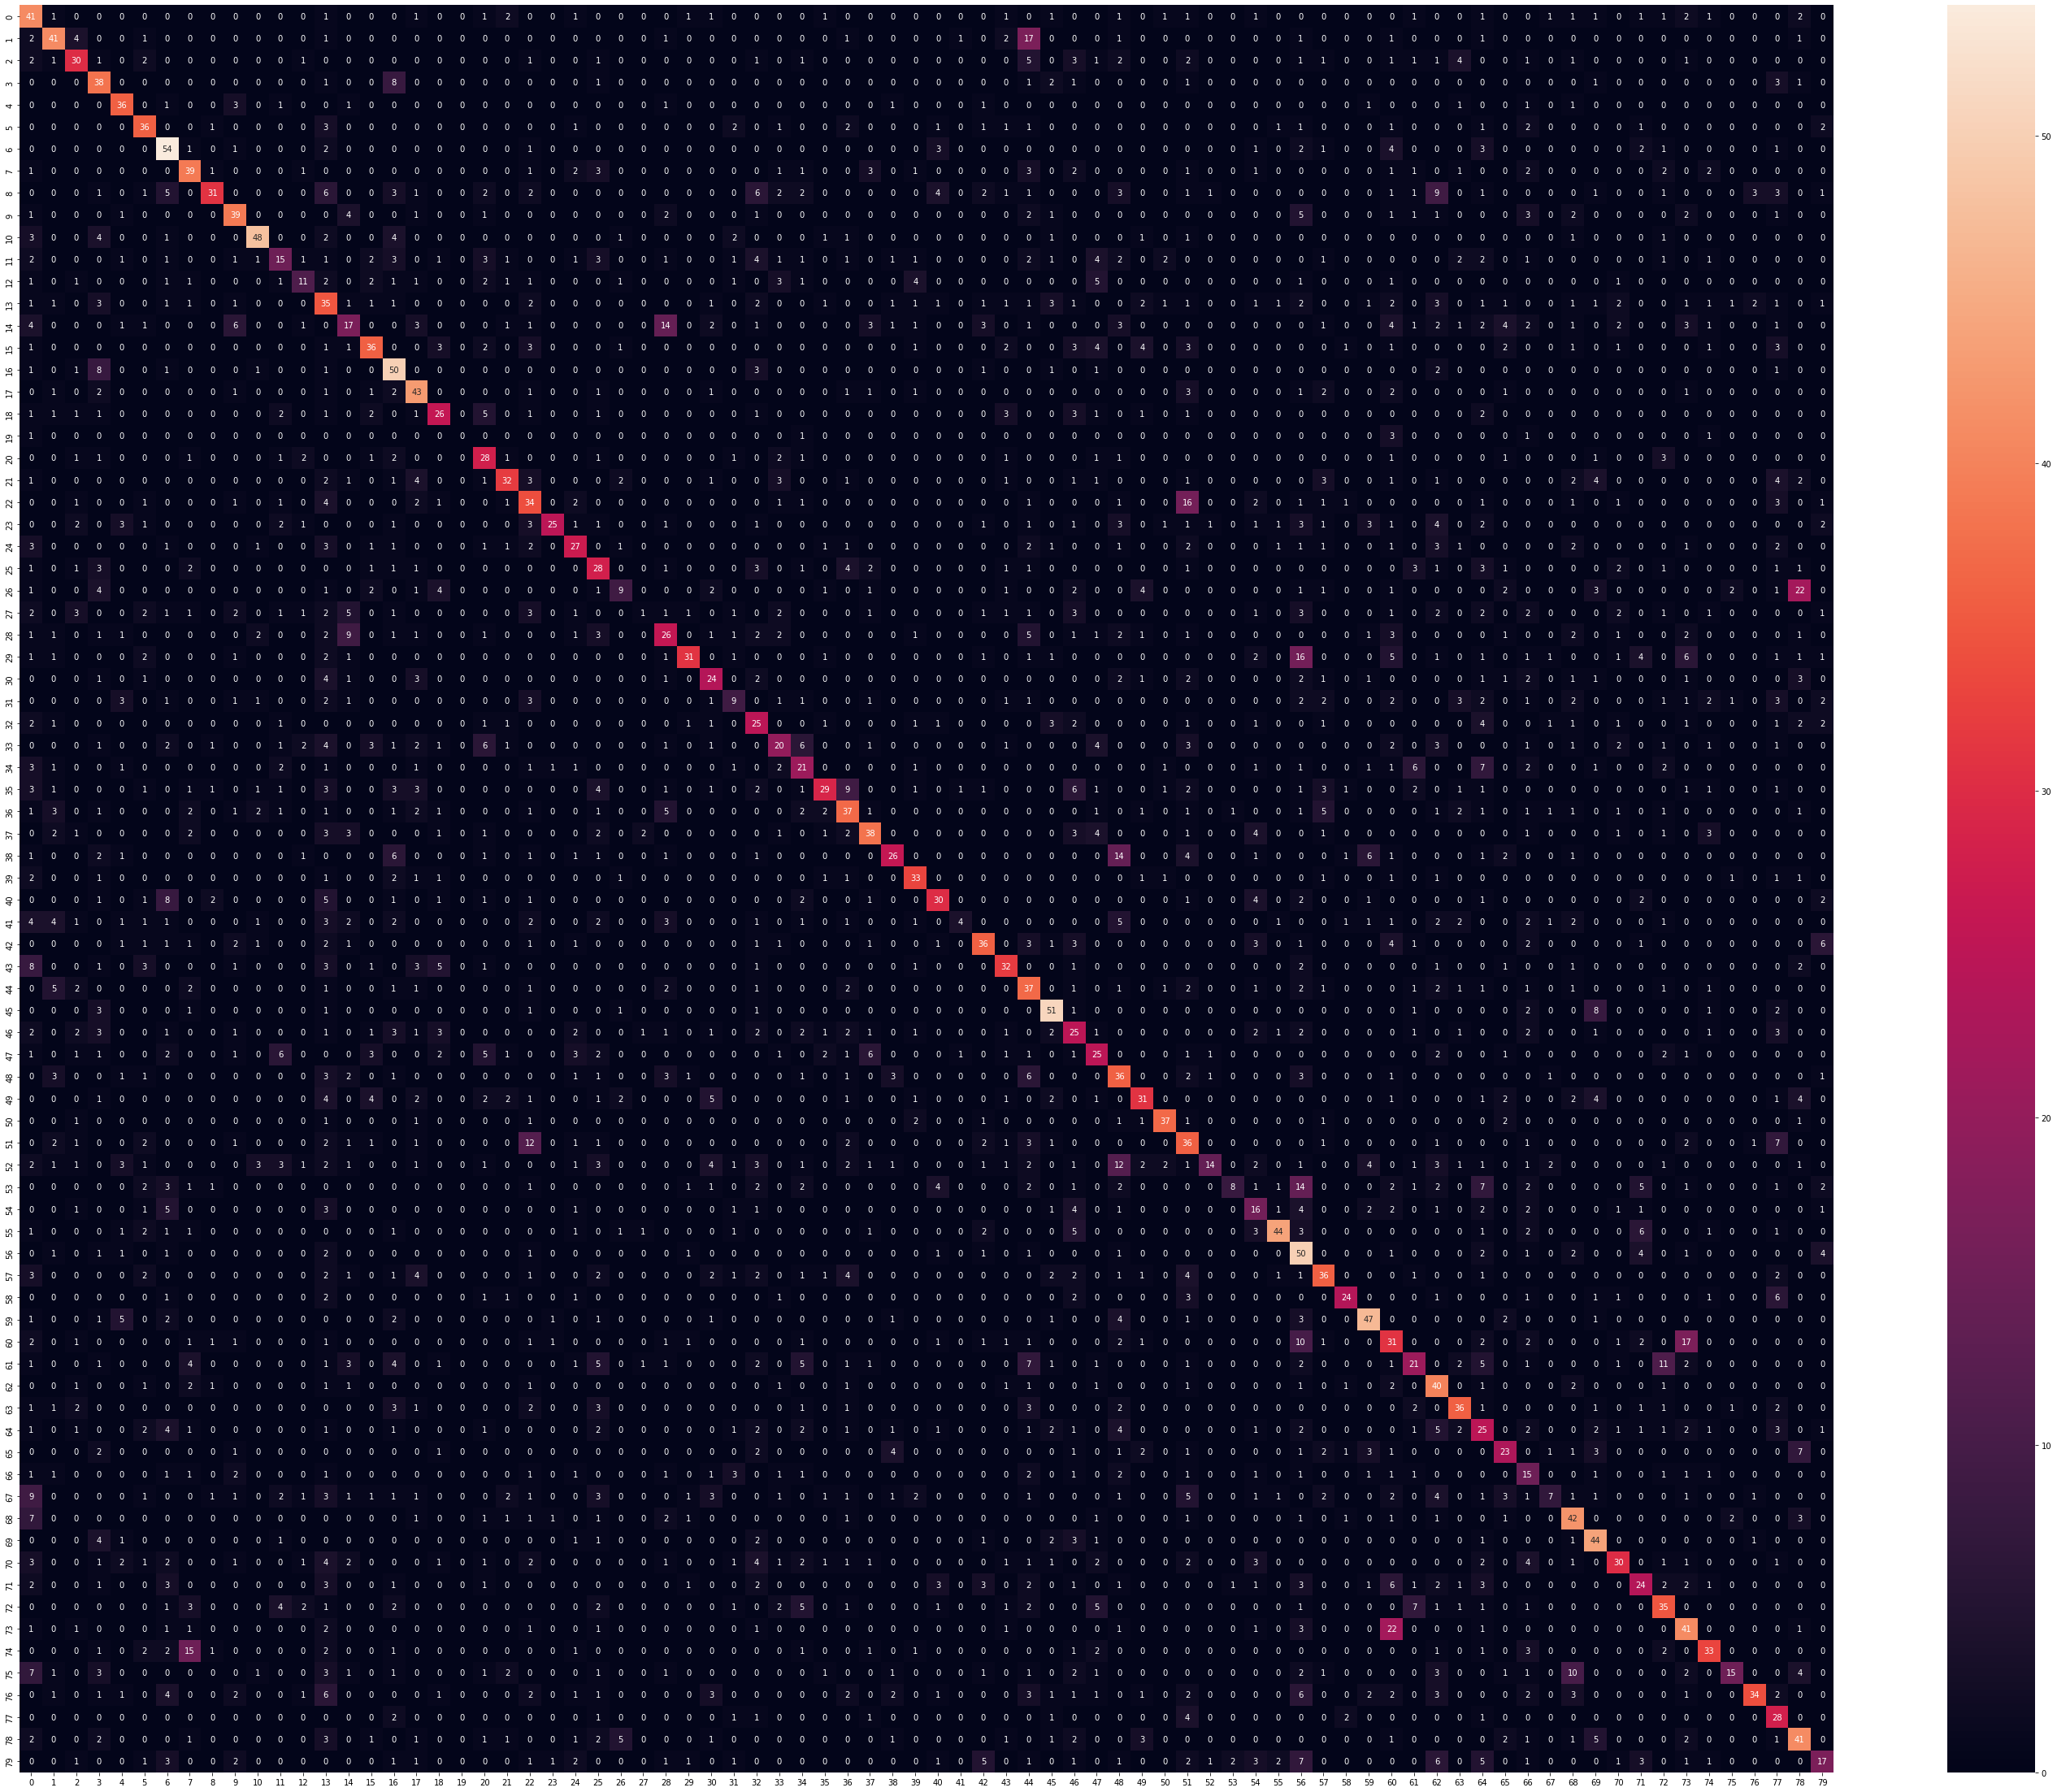

In [75]:
import seaborn as sns
plt.figure(figsize=(50, 40))
sns.heatmap(confusion_matrices[-1], annot=True)

In [102]:
c_matrix = np.array(confusion_matrices[-1])
tps = []
fns = []
fps = []
tns = []
prec = []
most_mistakes = []
# print(c_matrix)
for i in range(80):
    tps.append(c_matrix[i,i])
    fps.append(np.sum(c_matrix[i,:]) - c_matrix[i,i])
    fns.append(np.sum(c_matrix[:,i]) - c_matrix[i,i])
    tns.append(np.sum(c_matrix) - tps[i] - fps[i] - fns[i])
    prec.append([i, (tps[i]) / (tps[i]+fps[i])])
    matrix_copy = c_matrix.copy()
    matrix_copy[i,i] = 0
    most_mistakes.append([matrix_copy[i].argmax(), matrix_copy[i, matrix_copy[i].argmax()]])
    

class_names = np.load('class_names.npy', allow_pickle=True).item()
class_names = dict(sorted(class_names.items()))
print(class_names)
df_prec = pd.DataFrame(prec).drop(0, axis=1)
df_prec.index += 1
df_prec = df_prec.rename(index=class_names)
df_prec = df_prec.rename(columns={1:'precision'})
df_prec['most_confused'] = np.array(most_mistakes, dtype=int)[:,0]
df_prec['mistakes'] = np.array(most_mistakes, dtype=int)[:,1]
df_prec

{1: 'lasagna', 2: 'grilled_cheese_sandwich', 3: 'strudel', 4: 'greek_salad', 5: 'scotch_egg', 6: 'waffle', 7: 'chocolate_mousse', 8: 'brisket', 9: 'compote', 10: 'croquette', 11: 'stuffed_peppers', 12: 'confit', 13: 'salisbury_steak', 14: 'ambrosia_food', 15: 'fritter', 16: 'beef_stroganoff', 17: 'caprese_salad', 18: 'fried_calamari', 19: 'poutine', 20: 'marble_cake', 21: 'beef_bourguignonne', 22: 'chicken_curry', 23: 'dumpling', 24: 'crumpet', 25: 'tamale', 26: 'grilled_salmon', 27: 'pilaf', 28: 'rugulah', 29: 'crab_cake', 30: 'coconut_cake', 31: 'scrambled_eggs', 32: 'haggis', 33: 'tuna_tartare', 34: 'carbonnade_flamande', 35: 'entrecote', 36: 'lobster_food', 37: 'crab_food', 38: 'barbecued_wing', 39: 'poached_egg', 40: 'spaghetti_bolognese', 41: 'frozen_yogurt', 42: 'welsh_rarebit', 43: 'donut', 44: 'rigatoni', 45: 'ham_sandwich', 46: 'edamame', 47: 'taco', 48: 'adobo', 49: 'croque_madame', 50: 'risotto', 51: 'spaghetti_carbonara', 52: 'wonton', 53: 'bacon_and_eggs', 54: 'cheesecake

,precision,most_confused,mistakes
lasagna,0.594203,21,2
grilled_cheese_sandwich,0.539474,44,17
strudel,0.454545,44,5
greek_salad,0.655172,16,8
scotch_egg,0.734694,9,3
...,...,...,...
tamale_pie,0.220588,68,10
applesauce,0.365591,13,6
pho,0.666667,51,4
fried_rice,0.493976,26,5


In [69]:
# Julian
# save
PATH = './AML_net.pth'
torch.save(model.state_dict(), PATH)

# load
# model = TheModelClass(*args, **kwargs)
# model.load_state_dict(torch.load(PATH))
# model.eval()


#CASPER

print(train_data_list)
print(val_data_list)

list_train_loss = []
list_train_acc = []
for i in range(len(train_data_list)):
    list_train_loss.append(train_data_list[i][0].item())
    list_train_acc.append(train_data_list[i][1])
    
list_val_loss = []
list_val_acc = []
for i in range(len(val_data_list)):
    list_val_loss.append(val_data_list[i][0])
    list_val_acc.append(val_data_list[i][1])
               
print("train loss: ", list_train_loss)
print("val loss: ",list_val_loss)
print()
print("train acc: ",list_train_acc)
print("val acc: ",list_val_acc)

[(tensor(2.7184, device='cuda:0', grad_fn=<NllLossBackward0>), 29.057944383192453), (tensor(1.9496, device='cuda:0', grad_fn=<NllLossBackward0>), 45.5878149373188), (tensor(2.0344, device='cuda:0', grad_fn=<NllLossBackward0>), 49.28335170893054)]
[(2.454092418154081, 41.450269475747184), (2.21259847159187, 45.631226522946264), (2.1462704986333847, 47.46039523109587)]
train loss:  [2.7184042930603027, 1.9496327638626099, 2.034428834915161]
val loss:  [2.454092418154081, 2.21259847159187, 2.1462704986333847]

train acc:  [29.057944383192453, 45.5878149373188, 49.28335170893054]
val acc:  [41.450269475747184, 45.631226522946264, 47.46039523109587]


[1, 2, 3]


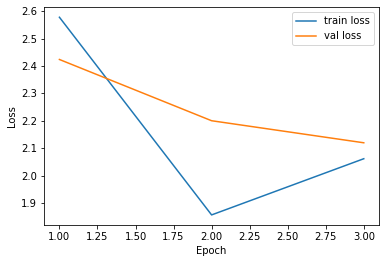

In [ ]:
import matplotlib.pyplot as plt

y = list(range(1,epochs+1))
print(y)

x1 = list_train_loss
x2 = list_val_loss
plt.plot(y,x1, label = "train loss")
plt.plot(y,x2, label = "val loss")

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

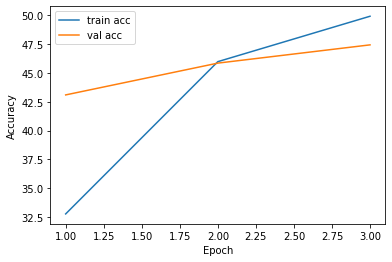

In [ ]:
x1 = list_train_acc
x2 = list_val_acc
plt.plot(y, x1, label = "train acc")
plt.plot(y, x2, label = "val acc")

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

<AxesSubplot:title={'center':'Data Distribution'}, xlabel='Class'>

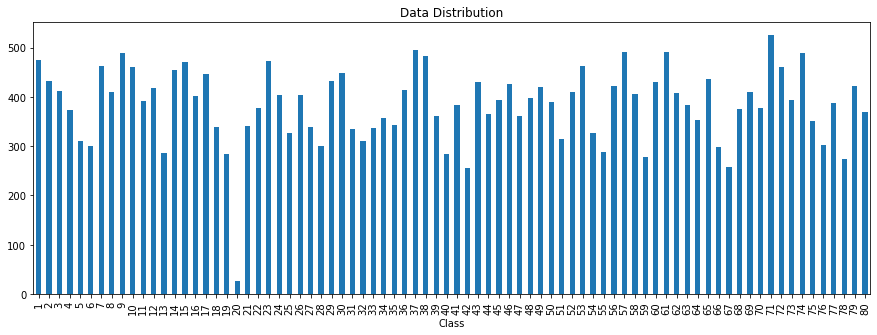

In [41]:
train_labels = pd.read_csv('train_labels.csv')
hist = train_labels.groupby('label').count().rename(columns={'img_name':'Count'})
hist.plot.bar(figsize=(15, 5), legend=False, title='Data Distribution', xlabel='Class', ylabel='')

# Test model

In [ ]:
# call test loop
predicted_labels = [item[0].item() + 1 for item in test_loop(test_dataloader, model)] # +1 to get the classes right

# update csv labels with predicted labels
sample = pd.read_csv(annotations_file_test)
sample['label'] = pd.Series(predicted_labels).values

In [ ]:
# create submission file
sample.to_csv('Project/submission.csv', index = False, header = True)

# print submission file
predicted_labels = pd.read_csv('Project/submission.csv'); predicted_labels

# Best model and parameters so far

**Model**                
> resnet18

**Batch size**           
> 256

**Learning rate**      
> 0.0001

**Epochs**
> 10

**Score**
> .60133